# Housing Price Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#prices = pd.read_csv('imputeImpl2_cat_housingData.csv',na_filter = False,index_col=0)
prices = pd.read_csv('../../data/Ames_Housing_Price_Data.csv',index_col = 0)
latlon = pd.read_csv('../../data/full_latlon.csv')

In [2]:
prices.reset_index(drop = True, inplace = True)
nulls = prices.isnull().sum(axis = 0)
nulls[nulls>1]

LotFrontage      462
Alley           2412
MasVnrType        14
MasVnrArea        14
BsmtQual          69
BsmtCond          69
BsmtExposure      71
BsmtFinType1      69
BsmtFinType2      70
BsmtFullBath       2
BsmtHalfBath       2
FireplaceQu     1241
GarageType       127
GarageYrBlt      129
GarageFinish     129
GarageQual       129
GarageCond       129
PoolQC          2571
Fence           2055
MiscFeature     2483
dtype: int64

In [3]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PID            2580 non-null   int64  
 1   GrLivArea      2580 non-null   int64  
 2   SalePrice      2580 non-null   int64  
 3   MSSubClass     2580 non-null   int64  
 4   MSZoning       2580 non-null   object 
 5   LotFrontage    2118 non-null   float64
 6   LotArea        2580 non-null   int64  
 7   Street         2580 non-null   object 
 8   Alley          168 non-null    object 
 9   LotShape       2580 non-null   object 
 10  LandContour    2580 non-null   object 
 11  Utilities      2580 non-null   object 
 12  LotConfig      2580 non-null   object 
 13  LandSlope      2580 non-null   object 
 14  Neighborhood   2580 non-null   object 
 15  Condition1     2580 non-null   object 
 16  Condition2     2580 non-null   object 
 17  BldgType       2580 non-null   object 
 18  HouseSty

In [4]:
prices = pd.merge(prices, latlon, how='left', left_on = 'PID', right_on = 'PID' )
prices.drop('coord',axis = 1,inplace = True)


In [5]:
#Exclude neighborhoods outside the Ames, IA city limits
prices = prices.drop_duplicates()
prices = prices.loc[~prices['Neighborhood'].isin(['Landmrk','Greens','GrnHill'])]

### Convert distances from km to miles

In [6]:
prices[['dist_airport','dist_downtown','dist_stadium']] = prices[['dist_airport','dist_downtown',
                                                                 'dist_stadium']].apply(lambda D: D*0.621371)
# prices['dist_airport']=prices['dist_airport']*0.621371
# prices['dist_downtown']=prices['dist_downtown']*0.621371
# prices['dist_stadium']=prices['dist_stadium']*0.621371


In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2568 entries, 0 to 2629
Data columns (total 86 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PID            2568 non-null   int64  
 1   GrLivArea      2568 non-null   int64  
 2   SalePrice      2568 non-null   int64  
 3   MSSubClass     2568 non-null   int64  
 4   MSZoning       2568 non-null   object 
 5   LotFrontage    2110 non-null   float64
 6   LotArea        2568 non-null   int64  
 7   Street         2568 non-null   object 
 8   Alley          168 non-null    object 
 9   LotShape       2568 non-null   object 
 10  LandContour    2568 non-null   object 
 11  Utilities      2568 non-null   object 
 12  LotConfig      2568 non-null   object 
 13  LandSlope      2568 non-null   object 
 14  Neighborhood   2568 non-null   object 
 15  Condition1     2568 non-null   object 
 16  Condition2     2568 non-null   object 
 17  BldgType       2568 non-null   object 
 18  HouseSty

In [8]:
prices['MasVnrType'].fillna(prices['MasVnrType'].mode()[0],inplace = True)
prices['MasVnrArea'].fillna(prices['MasVnrArea'].mode()[0],inplace = True)
prices['Electrical'].fillna(prices['Electrical'].mode()[0],inplace = True)


In [9]:
#Creating a price per square foot column to help with feature engineering
prices['Price_sqft'] = prices['SalePrice']/prices['GrLivArea']

tree_prices = prices.copy()

# Converting quality/condition categoricals to numerical

In [10]:
def ordinal_scale(Series):
    '''Returns a pandas Series where quality scores are converted to integers
    
    Args:
    
    Series: a pandas Series of categorical quality scores'''
    return Series.replace({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})

prices['KitchenQual'] = ordinal_scale(prices['KitchenQual'])
prices['ExterQual'] = ordinal_scale(prices['ExterQual'])
prices['ExterCond'] = ordinal_scale(prices['ExterCond'])
prices['HeatingQC'] = ordinal_scale(prices['HeatingQC'])

In [11]:
def fillna_cats(Series):
    '''
    Returns a categorical pandas series replacing null values with DNE (Does Not Exist).
    
    Args:
    

    Series: str, column name in the pandas dataframe.
    '''
    Series.fillna('DNE',inplace = True)
    return Series
    
impute_cols = ['Alley','BsmtExposure','BsmtFinType1',
               'BsmtFinType2','Fence']
ordinal_cols = ['BsmtQual','BsmtCond','FireplaceQu','GarageQual',
                'GarageCond','PoolQC','GarageType','GarageFinish']

for i in impute_cols:
    prices[i] = fillna_cats(prices[i])
    tree_prices[i] =  fillna_cats(tree_prices[i])

for j in ordinal_cols:
    prices[j] = fillna_cats(prices[j])
    tree_prices[j] = fillna_cats(tree_prices[j])

In [12]:
def impute_by_neighborhood(df,Series,method):
    if not isinstance(df, pd.DataFrame):
        raise TypeError('df argument must be of type DataFrame')
    
    
    return df[Series].fillna(df.groupby('Neighborhood')[Series].transform(method))

tree_prices['MiscFeature'] = fillna_cats(tree_prices['MiscFeature'])

tree_prices['LotFrontage'] = impute_by_neighborhood(tree_prices,'LotFrontage','mean')
tree_prices['GarageYrBlt'] = impute_by_neighborhood(tree_prices,'GarageYrBlt','median')


prices['LotFrontage'] = impute_by_neighborhood(prices,'LotFrontage','mean')
prices['GarageYrBlt'] = impute_by_neighborhood(prices,'GarageYrBlt','median')

tree_prices = tree_prices.fillna(tree_prices.mean())

tree_nulls = tree_prices.isnull().sum()
tree_nulls[tree_nulls>1]

Series([], dtype: int64)

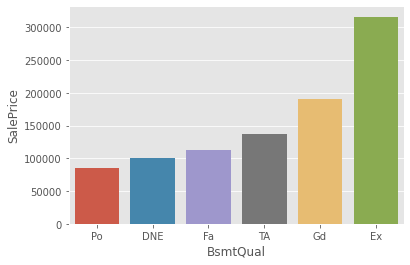

In [13]:
def cat_medians(Series):
    import seaborn as sns
    import matplotlib.pyplot as plt
    bars = prices.groupby(Series)['SalePrice'].median().reset_index().sort_values(by = 'SalePrice')
    sns.barplot(data = bars, x = Series,y = 'SalePrice')

    
cat_medians('BsmtQual')

In [14]:
for i in ordinal_cols:
    prices[i].replace({'Po':0,'DNE':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},inplace = True)

In [15]:
prices['MiscFeature'].fillna(0,inplace = True)
prices['MiscFeature'] = prices['MiscFeature'].apply(lambda M: 1 if M !=0 else M)
prices['CentralAir'].replace({'N':0,'Y':1},inplace = True)
prices['Street'].replace({'Grvl':0,'Pave':1},inplace = True)
prices['PavedDrive'].replace({'Y':1,'P':0.5,'N':0},inplace = True)
prices['Utilities'].replace({'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO':1},inplace = True)

In [16]:
prices = prices.fillna(prices.mean())

nulls = prices.isnull().sum(axis = 0)
nulls[nulls>1]

Series([], dtype: int64)

In [17]:
def check_frontage(boro):
    x = prices['LotFrontage'].loc[prices['Neighborhood']==boro]
    plt.figure(figsize = (6,6))
    plt.title(f'LotFrontage distribution for {boro}')
    return plt.hist(x)

(array([ 2.,  2.,  4., 20., 81.,  9.,  1.,  2.,  0.,  2.]),
 array([ 46. ,  54.4,  62.8,  71.2,  79.6,  88. ,  96.4, 104.8, 113.2,
        121.6, 130. ]),
 <BarContainer object of 10 artists>)

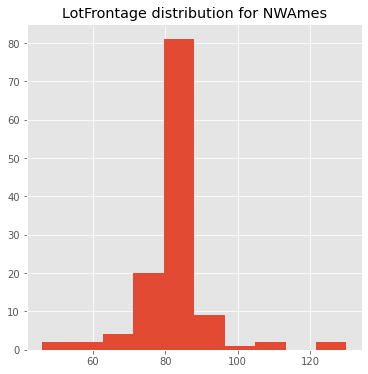

In [18]:
check_frontage('NWAmes')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'SWISU'),
  Text(1, 0, 'Edwards'),
  Text(2, 0, 'IDOTRR'),
  Text(3, 0, 'OldTown'),
  Text(4, 0, 'NWAmes'),
  Text(5, 0, 'Blmngtn'),
  Text(6, 0, 'Mitchel'),
  Text(7, 0, 'NridgHt'),
  Text(8, 0, 'NAmes'),
  Text(9, 0, 'CollgCr'),
  Text(10, 0, 'SawyerW'),
  Text(11, 0, 'MeadowV'),
  Text(12, 0, 'BrDale'),
  Text(13, 0, 'Gilbert'),
  Text(14, 0, 'Timber'),
  Text(15, 0, 'Somerst'),
  Text(16, 0, 'BrkSide'),
  Text(17, 0, 'NoRidge'),
  Text(18, 0, 'Sawyer'),
  Text(19, 0, 'Crawfor'),
  Text(20, 0, 'ClearCr'),
  Text(21, 0, 'StoneBr'),
  Text(22, 0, 'Veenker'),
  Text(23, 0, 'NPkVill'),
  Text(24, 0, 'Blueste')])

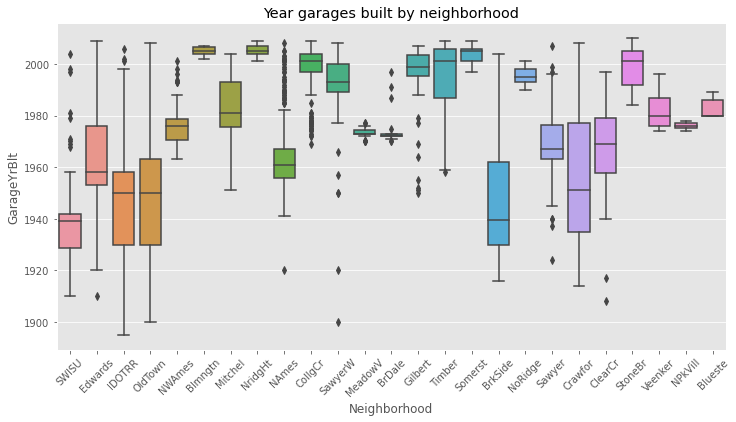

In [19]:
plt.figure(figsize = (12,6))
plt.title('Year garages built by neighborhood')
sns.boxplot(data = prices, x = 'Neighborhood', y = 'GarageYrBlt')
plt.xticks(rotation = 45,labels=None)

# Selecting numerical variables for multiple linear regression

In [20]:
# categorical_features = new_prices.select_dtypes(include = object)
# for i in categorical_features:
#     categorical_features[i].fillna(categorical_features[i].mode()[0], inplace=True)

# categorical_features = pd.get_dummies(categorical_features)
numeric_features = prices.select_dtypes(include = np.number).copy()

# numeric_features =pd.concat([categorical_features, numeric_features], axis=1)



y_price = np.log(numeric_features['SalePrice'])
numeric_features.drop(['PID','SalePrice','Price_sqft','MSSubClass'], axis = 1, inplace = True)



# OHE categorical values to numerical

In [21]:
# print(len(categorical_features.columns))
# categorical_features.columns

In [22]:
#prices = pd.get_dummies(prices,columns=['GarageFinish','SaleCondition'])



# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(handle_unknown='ignore')
# ohe.fit_transform(categorical_features['GarageFinish'].astype(str))

In [23]:
numeric_features.columns

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'Street', 'Utilities',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal', 'MoSold',
       'YrSold', 'lat', 'lon', 'dist_stadium', 'dist_downtown',
       'dist_airport'],
      dtype='object')

In [24]:
#categorical_features['GarageType'].value_counts()

<AxesSubplot:>

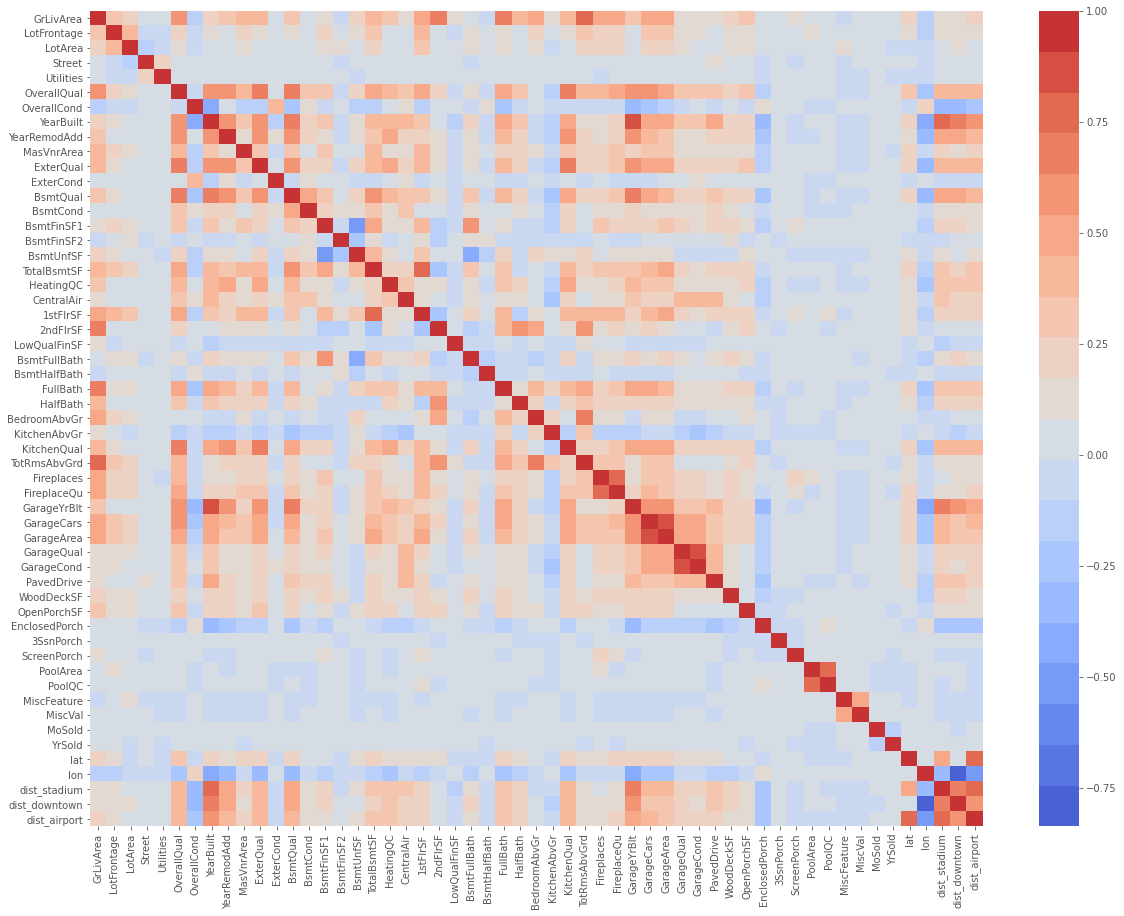

In [25]:
plt.figure(figsize = (20,15))
colormap = sns.color_palette('coolwarm',20)
sns.heatmap(numeric_features.corr(),cmap = colormap)

In [26]:
r_prices = prices.corr()
r_prices = r_prices[['SalePrice']][1:]

<AxesSubplot:>

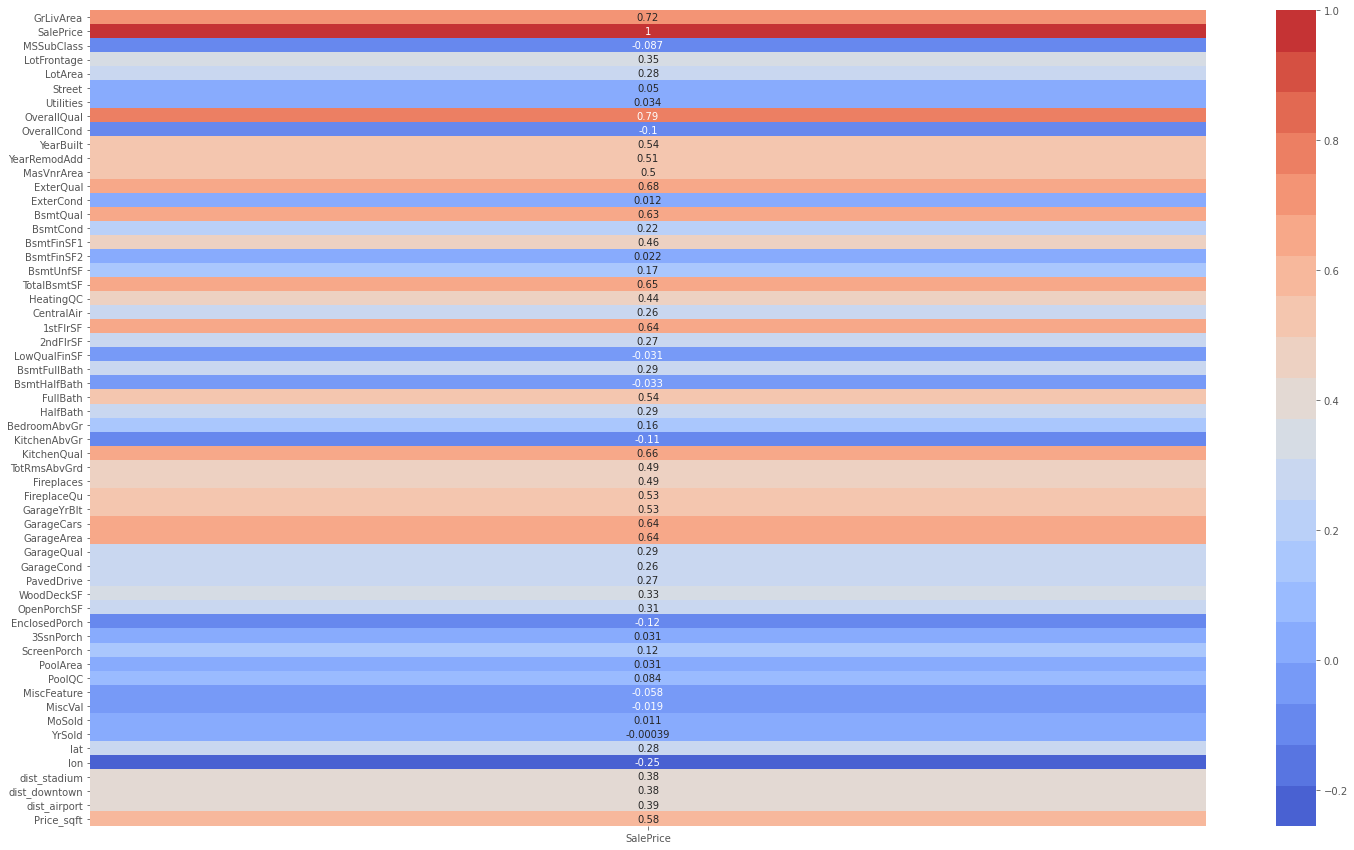

In [27]:
plt.figure(figsize = (25,15))
sns.heatmap(r_prices,annot = True,cmap = colormap)

In [28]:
numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2568 entries, 0 to 2629
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2568 non-null   int64  
 1   LotFrontage    2568 non-null   float64
 2   LotArea        2568 non-null   int64  
 3   Street         2568 non-null   int64  
 4   Utilities      2568 non-null   int64  
 5   OverallQual    2568 non-null   int64  
 6   OverallCond    2568 non-null   int64  
 7   YearBuilt      2568 non-null   int64  
 8   YearRemodAdd   2568 non-null   int64  
 9   MasVnrArea     2568 non-null   float64
 10  ExterQual      2568 non-null   int64  
 11  ExterCond      2568 non-null   int64  
 12  BsmtQual       2568 non-null   int64  
 13  BsmtCond       2568 non-null   int64  
 14  BsmtFinSF1     2568 non-null   float64
 15  BsmtFinSF2     2568 non-null   float64
 16  BsmtUnfSF      2568 non-null   float64
 17  TotalBsmtSF    2568 non-null   float64
 18  HeatingQ

# Distribution of numerical variables

In [29]:
numeric_colnames = numeric_features.columns
len(numeric_colnames)

55

Median is 159500.0
Mean is 177941.81386292833


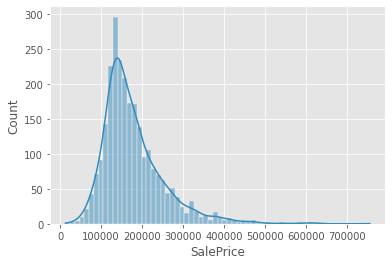

In [30]:
sns.histplot(prices.SalePrice,kde = True)
print(f'Median is {np.median(prices.SalePrice)}')
print(f'Mean is {np.mean(prices.SalePrice)}')

Text(0.5, 1.0, 'Distribution of numerical variables')

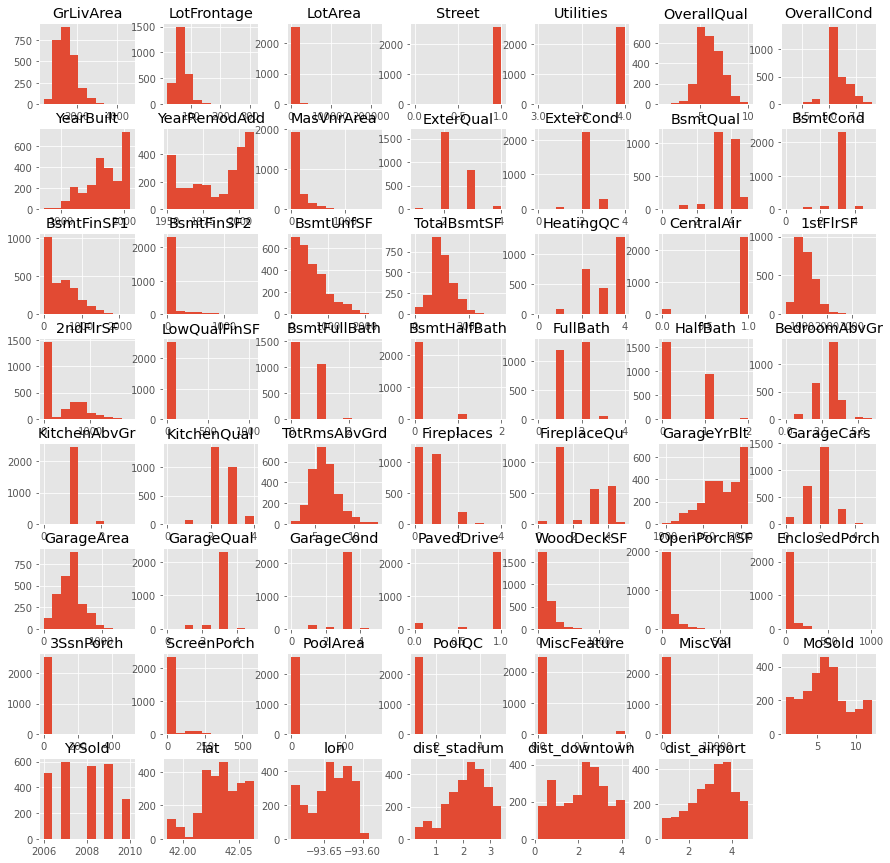

In [31]:
numeric_features.hist(figsize = (15,15))
plt.title('Distribution of numerical variables')

### Five fold CV using KFold

<p> Gabi says drop garagecars, garagequal and garagecondition</p>

In [32]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso


Xtrain,Xtest,ytrain,ytest = train_test_split(numeric_features,y_price)

from sklearn.preprocessing import StandardScaler,OneHotEncoder
sc = StandardScaler()
cv = KFold(n_splits = 5, shuffle = True)


from sklearn.linear_model import Lasso
lasso = Lasso(max_iter = 3500000)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
# pipe = Pipeline(steps = [('ss',StandardScaler()),('lasso',lasso)])

alphas = np.linspace(.00001,0.02,1000)

cv_res=[]

for alpha in alphas:
    lasso.set_params(alpha = alpha)
    pipe = Pipeline(steps = [('ss',StandardScaler()),('lasso',lasso)])
    cv_res.append(cross_validate(pipe, Xtrain,ytrain,cv = cv, return_train_score = True))

In [33]:
lasso_test = [i['test_score'].mean() for i in cv_res]
lasso_train = [i['train_score'].mean() for i in cv_res]

Text(0, 0.5, 'Coefficient of Determination')

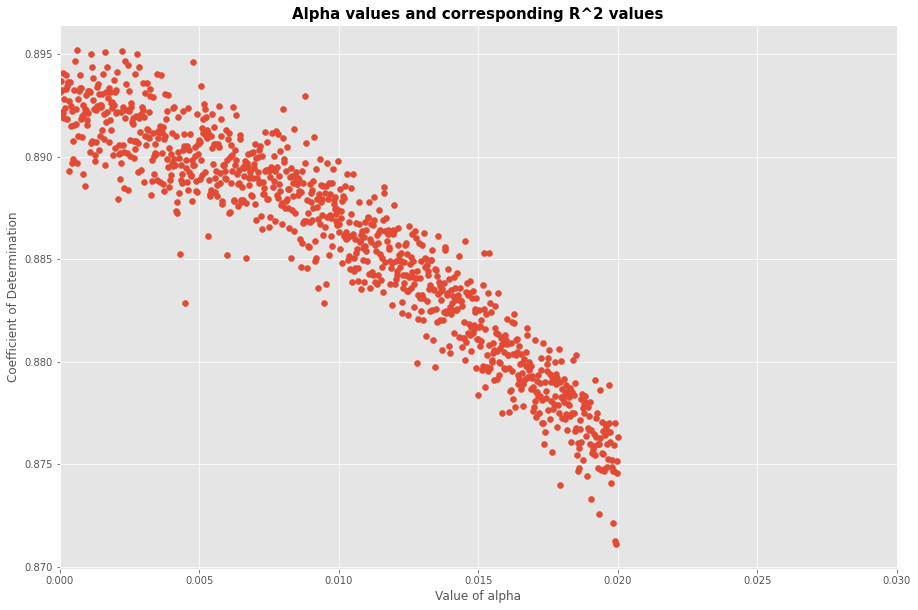

In [34]:
plt.figure(figsize = (15,10))
plt.scatter(alphas, lasso_test)
plt.xlim([0,0.03])
plt.title(r'Alpha values and corresponding R^2 values',fontsize = 15, fontweight = 'bold')
plt.xlabel('Value of alpha')
plt.ylabel('Coefficient of Determination')

In [35]:
alpha_ind = lasso_test.index(max(lasso_test))
f'alpha: {alphas[alpha_ind]}, train_score: {lasso_train[alpha_ind]}, test_score: {lasso_test[alpha_ind]}'

'alpha: 0.0006103003003003004, train_score: 0.9027682301370724, test_score: 0.8951961150950577'

In [36]:
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)
lasso = Lasso()
lasso.set_params(alpha = alphas[alpha_ind])
lasso.fit(Xtrain,ytrain)

lasso_train_results = lasso.score(Xtrain,ytrain)
lasso_test_results = lasso.score(Xtest,ytest)
print(lasso_train_results)
print(lasso_test_results)

0.9017744814558173
0.926287633940513


In [37]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()

ols.fit(Xtrain,ytrain)

print(f'MLR training score: {ols.score(Xtrain,ytrain)}')
print(f'MLR testing score: {ols.score(Xtest,ytest)}')

from sklearn.metrics import mean_squared_error
y_pred = ols.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'RMSE: {RMSE}')

MLR training score: 0.9022627158359152
MLR testing score: 0.9255458526124477
RMSE: 0.10518850592036112


In [38]:
for col, coef in zip(numeric_features.columns,lasso.coef_):
    print(f'{col}:   {coef}')

GrLivArea:   0.10559261913151002
LotFrontage:   0.021490626401344602
LotArea:   0.021469304393025572
Street:   0.003908760968116404
Utilities:   0.0030692900970856673
OverallQual:   0.09020072256869374
OverallCond:   0.05119635967769862
YearBuilt:   0.0647920735784468
YearRemodAdd:   0.011588021295342395
MasVnrArea:   0.0
ExterQual:   0.00997969854195823
ExterCond:   0.0005227783837186375
BsmtQual:   0.014895112240829811
BsmtCond:   0.0008825553666645285
BsmtFinSF1:   0.028383449896566708
BsmtFinSF2:   0.004439401960722858
BsmtUnfSF:   -0.0
TotalBsmtSF:   0.03438538407140274
HeatingQC:   0.020334641706806027
CentralAir:   0.012230084419417486
1stFlrSF:   0.01506798311312815
2ndFlrSF:   0.0
LowQualFinSF:   -0.005215024479715729
BsmtFullBath:   0.012301940042965634
BsmtHalfBath:   0.003618314929013755
FullBath:   0.008046630737079811
HalfBath:   0.0034594731462627083
BedroomAbvGr:   -0.002748908316240175
KitchenAbvGr:   -0.011029597566777552
KitchenQual:   0.011078966771991652
TotRmsAbvG

In [39]:
coefs = lasso.coef_
zero_idx = np.where(coefs == 0)
numeric_features.columns[zero_idx]

Index(['MasVnrArea', 'BsmtUnfSF', '2ndFlrSF', 'MiscFeature', 'dist_airport'], dtype='object')

# Drop Features Post-lasso

In [40]:
post_lasso = numeric_features.drop(numeric_features.columns[zero_idx],axis = 1)

In [41]:
print(len(post_lasso.columns))

print(len(numeric_features.columns))

50
55


In [42]:
Xtrain,Xtest,ytrain,ytest = train_test_split(post_lasso,y_price)

Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)


ols2 = LinearRegression()
ols2.fit(Xtrain,ytrain)

LinearRegression()

In [43]:
print(f'Post-lasso training score: {ols2.score(Xtrain,ytrain)}')
print(f'Post-lasso testing score: {ols2.score(Xtest,ytest)}')

y_pred = ols2.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared=False)
print(f'Post-lasso RMSE: {RMSE}')

Post-lasso training score: 0.9105285022018728
Post-lasso testing score: 0.8991930205760046
Post-lasso RMSE: 0.1261258859662534


# Five-Fold cross-validation for OLS

In [44]:
pipe = Pipeline(steps = [('ss',StandardScaler()),('ols',LinearRegression())])
cv_res2 =cross_validate(pipe, post_lasso,y_price ,cv = cv, return_train_score = True)

In [45]:
print(f"Testing score: {cv_res2['test_score'].mean()}")
print(f"Training score: {cv_res2['train_score'].mean()}")

Testing score: -6.994281593425178e+19
Training score: 0.9091746077020973


In [46]:
cv_res2

{'fit_time': array([0.02011514, 0.01778793, 0.01570582, 0.01739979, 0.01648903]),
 'score_time': array([0.00215197, 0.00149894, 0.00124216, 0.00122809, 0.00127721]),
 'test_score': array([ 9.00248700e-01,  8.86777327e-01,  9.27645492e-01, -3.49714080e+20,
         8.77386815e-01]),
 'train_score': array([0.90709537, 0.91312284, 0.90289084, 0.9091627 , 0.91360128])}

In [47]:
np.mean(cv_res2['test_score'])

-6.994281593425178e+19

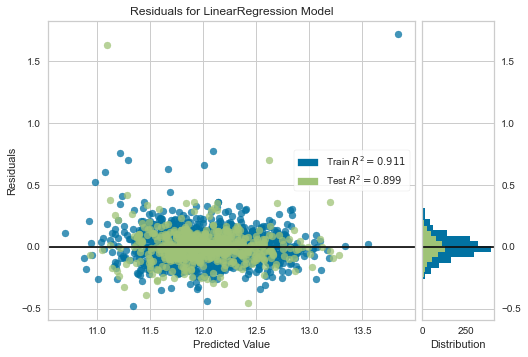

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [48]:
from yellowbrick.regressor import ResidualsPlot
ols2 = LinearRegression()
visualizer = ResidualsPlot(ols2)
visualizer.fit(Xtrain, ytrain) 
visualizer.score(Xtest, ytest)  
visualizer.show() 

Text(0.5, 1.0, 'Standardized betas in log(SalePrice) linear model')

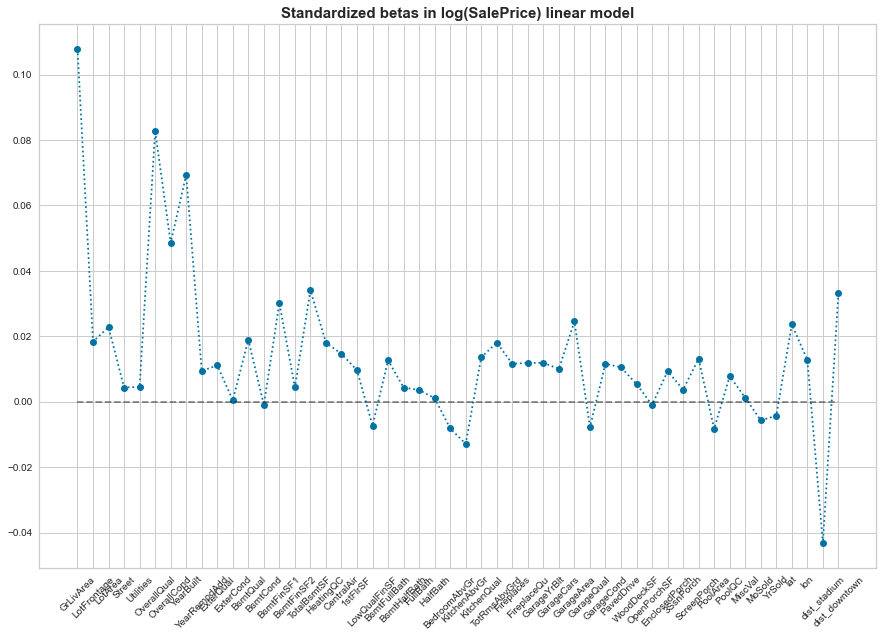

In [49]:
plt.figure(figsize = (15,10))
plt.plot(list(range(len(post_lasso.columns))),ols2.coef_,'bo:')
plt.plot(list(range(len(post_lasso.columns))),np.array([0 for zero in range(len(post_lasso.columns))]),'k--',alpha = 0.49)
plt.xticks(list(range(len(post_lasso.columns))),labels = post_lasso.columns, rotation = 45)
plt.title('Standardized betas in log(SalePrice) linear model', fontsize = 15, fontweight = 'bold')

<p>Most influential features in the linear model are GrLivArea, OverallQual, OverallCond, and YearBuilt</p>

In [50]:
import statsmodels.api as sm
Y = ytrain
X = Xtrain
X = sm.add_constant(X)
OLS = sm.OLS(ytrain,Xtrain)
results = OLS.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.026
Method:                 Least Squares   F-statistic:                            0.03495
Date:                Sat, 06 Mar 2021   Prob (F-statistic):                        1.00
Time:                        17:49:42   Log-Likelihood:                         -7521.6
No. Observations:                1926   AIC:                                  1.514e+04
Df Residuals:                    1876   BIC:                                  1.542e+04
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Gradient Boosting

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

LE = LabelEncoder()

tree_prices['MSSubClass'] = tree_prices['MSSubClass'].astype(str)

y_Logprice = np.log(tree_prices['SalePrice'])

tree_features = tree_prices.drop(['PID','SalePrice','Price_sqft'],axis = 1)

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
cat_cols = tree_features.select_dtypes(include = 'object').columns
num_cols = tree_features.select_dtypes(exclude = 'object').columns


ohe = OneHotEncoder(sparse = False,handle_unknown='ignore')

processing = ColumnTransformer(transformers = [('ohe',ohe, cat_cols),
                                               ('ss',StandardScaler(),num_cols)],remainder = 'passthrough')

#Xtrain,Xtest,ytrain,ytest = train_test_split(tree_features,y_Logprice)
tree_pipe = Pipeline(steps = [('process',processing),('gb',GradientBoostingRegressor())])
tree_pipe.fit(Xtrain,ytrain)


Pipeline(steps=[('process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1s...
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'lat', 'lon', 'dist_stadium', 'dist_downtown',
       'dist_airport'],
    

In [75]:
print(tree_pipe.score(Xtrain,ytrain))
print(tree_pipe.score(Xtest,ytest))

y_pred = tree_pipe.predict(Xtest)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'Gradient Boosting RMSE: {RMSE}')


0.963715203226535
0.9146908411161885
Gradient Boosting RMSE: 0.11033168413943685
0.9840017092881791
0.8857435858147155
Gradient Boosting RMSE: 0.12768583252728818


In [54]:
# cat_features = tree_features.select_dtypes(include = 'object')

# num_features = tree_features.select_dtypes(exclude = 'object')

# cat_features = pd.get_dummies(cat_features,drop_first = True)


# tree_df =pd.concat([cat_features, num_features], axis=1)

# Xtrain,Xtest,ytrain,ytest = train_test_split(tree_df,y_Logprice)

In [55]:
# train_cats = Xtrain.select_dtypes(include = 'object')
# test_cats = Xtest.select_dtypes(include = 'object')

# train_nums = Xtrain.select_dtypes(exclude = 'object')
# test_nums = Xtest.select_dtypes(exclude = 'object')


# train_cats.head(5)


In [56]:
# train_cats = OE.fit_transform(train_cats)
# test_cats = OE.transform(test_cats)

# train_cats.head()

In [57]:
# Xtrain = pd.concat([train_cats,train_nums],axis = 1)
# Xtrain = sc.fit_transform(Xtrain)
# Xtest = pd.concat([test_cats,test_nums],axis = 1)
# Xtest = sc.transform(Xtest)

In [58]:
from sklearn.ensemble import GradientBoostingRegressor

gBoost = GradientBoostingRegressor()

from sklearn.model_selection import GridSearchCV
# search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
# search=GridSearchCV(estimator=gBoost,param_grid=search_grid,n_jobs=1,cv=cv)
# search.fit(Xtrain,ytrain)

# search.best_params_

In [76]:
# # gBoost.set_params()
# gBoost.fit(Xtrain,ytrain)
# print(gBoost.score(Xtrain,ytrain))
# print(gBoost.score(Xtest,ytest))

tree_prices.BedroomAbvGr.value_counts()

3    1408
2     654
4     349
1      90
5      40
6      20
0       7
Name: BedroomAbvGr, dtype: int64

In [60]:
Xtrain,Xtest,ytrain,ytest = train_test_split(tree_features,y_Logprice)

# tree_pipe = Pipeline(steps = [('process',processing),('gb',GradientBoostingRegressor())])
tree_cv =cross_validate(tree_pipe, Xtrain,ytrain,cv = cv, return_train_score = True)

In [61]:
np.mean(tree_cv['test_score'])

0.9142433568266805

In [62]:
predicted_prices = np.exp(tree_pipe.predict(tree_features))

In [63]:
price_comp = pd.DataFrame({'Actual':tree_prices['SalePrice'],'Predicted':predicted_prices})

In [64]:
price_comp['Residuals'] = price_comp.Actual - price_comp.Predicted
price_comp['absResiduals'] = np.abs(price_comp['Residuals'])

In [65]:
price_comp.describe()

Actual      Predicted      Residuals   absResiduals
count    2568.000000    2568.000000    2568.000000    2568.000000
mean   177941.813863  176908.300590    1033.513273   10834.522434
std     75120.582411   71921.540097   15815.110764   11565.192981
min     12789.000000   16902.310647 -103129.540264       6.500309
25%    129900.000000  129699.138701   -7040.869020    3339.821905
50%    159500.000000  158473.350580     584.301331    7631.658171
75%    209500.000000  205448.131198    8365.457437   14252.307874
max    755000.000000  655994.899139  129439.717007  129439.717007

In [66]:
tree_prices['Predicted'] = price_comp.Predicted

In [67]:
tree_prices.head(10)

PID  GrLivArea  SalePrice MSSubClass MSZoning  LotFrontage  LotArea  \
0   909176150        856     126000         30       RL    58.769231     7890   
1   905476230       1049     139500        120       RL    42.000000     4235   
3   911128020       1001     124900         30  C (all)    60.000000     6060   
4   535377150       1039     114000         70       RL    80.000000     8146   
5   534177230       1665     227000         60       RL    70.000000     8400   
6   908128060       1922     198500         85       RL    64.000000     7301   
7   902135020        936      93000         20       RM    60.000000     6000   
8   528228540       1246     187687         20       RL    53.000000     3710   
9   923426010        889     137500         20       RL    74.000000    12395   
10  908186050       1072     140000        180       RM    35.000000     3675   

   Street Alley LotShape  ... YrSold SaleType SaleCondition        lat  \
0    Pave   DNE      Reg  ...   2010      WD         Normal  42.018564   
1    Pave   DNE      Reg  ...   2009      WD         Normal  42.024855   
3    Pave   DNE      Reg  ...   2007      WD         Normal  42.021548   
4    Pave   DNE      Reg  ...   2009      WD         Normal  42.037391   
5    Pave   DNE      Reg  ...   2009      WD         Normal  42.044554   
6    Pave   DNE      Reg  ...   2009    ConLD        Normal  42.019009   
7    Pave  Pave      Reg  ...   2009      WD         Normal  42.031162   
8    Pave   DNE      Reg  ...   2008      New       Partial  42.063284   
9    Pave   DNE      Reg  ...   2008      WD         Normal  41.986496   
10   Pave   DNE      Reg  ...   2007      WD         Normal  42.018966   

          lon dist_stadium dist_downtown dist_airport  Price_sqft  \
0  -93.651619     0.835068      1.997560     2.024702  147.196262   
1  -93.663671     1.558185      2.566078     2.777751  132.983794   
3  -93.614068     1.173123      0.245745     1.616918  124.775225   
4  -93.612207     1.897608      0.852123     2.704025  109.720885   
5  -93.631818     1.966935      1.631256     3.184678  136.336336   
6  -93.672987     1.928481      3.074472     2.950477  103.277836   
7  -93.612561     1.576285      0.423079     2.279611   99.358974   
8  -93.641569     3.263445      2.997337     4.548662  150.631621   
9  -93.603619     2.632937      2.715708     1.292634  154.668166   
10 -93.669462     1.747762      2.895315     2.790099  130.597015   

        Predicted  
0   123918.703997  
1   129807.737865  
3   120209.859414  
4   106169.543552  
5   209269.339249  
6   204099.447143  
7    86771.640748  
8   177156.584511  
9   138707.118371  
10  141843.290836  

[10 rows x 88 columns]

In [68]:
tree_prices['PriceBin'] = pd.qcut(tree_prices['SalePrice'],q=4,labels = ['Quart_1','Quart_2','Quart_3','Quart_4'])
tree_prices['Residuals'] = price_comp['Residuals']

Text(0, 0.5, 'Actual price - predicted price (USD)')

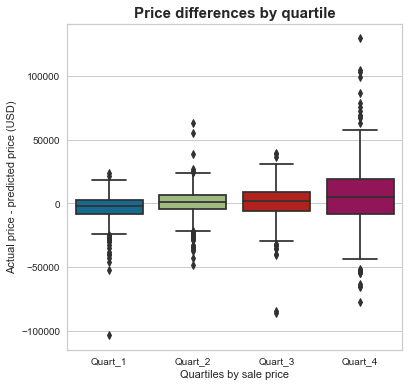

In [69]:
plt.figure(figsize = (6,6))
sns.boxplot(data = tree_prices, x = 'PriceBin', y = 'Residuals')
plt.title('Price differences by quartile',fontsize = 15, fontweight = 'bold')
plt.xlabel('Quartiles by sale price')
plt.ylabel('Actual price - predicted price (USD)')


In [70]:
tree_prices.groupby('PriceBin')[['SalePrice']].mean()

SalePrice
PriceBin               
Quart_1   106974.869767
Quart_2   143746.073437
Quart_3   181502.261275
Quart_4   280081.790625